In [2]:
%reset -f
import rdkit
import pycaret
import joblib

print('rdkit: %s' % rdkit.__version__)
print('pycaret: %s' % pycaret.__version__)
print('joblib: %s' % joblib.__version__)

rdkit: 2023.09.5
pycaret: 3.3.2
joblib: 1.3.2


In [3]:
%%time
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors

# Defining the SMILES strings for the cucumin varients
curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "N#Cc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

molecule_names = ['2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-14-Moore', 'AD-16-DMF', 'AD-18', 'AD-24', 'AD-25', 'AD-3', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-9', 'YD-30']
homo_lumo_gap = [3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 2.811, 3.231, 2.735, 2.878, 2.686, 3.215, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 3.137, 2.525]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)
curcumin_df['mol'] = curcumin_df['Smiles'].apply(Chem.MolFromSmiles)

# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=[
    'index', 'inchikey', 'HOMO_calc', 'LUMO_calc', 'LUMO_calib', 'LUMO_calib_stds',
    'HOMO_calib', 'HOMO_calib_stds','GAP_calc', 'molW', 'PCE_calc', 'Voc_calc', 'Jsc_calc',
    'FF_calc', 'EQE_calc', 'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib',
    'EQE_calib', 'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df['mol'] = opv_df['smiles'].apply(Chem.MolFromSmiles)

CPU times: total: 4.42 s
Wall time: 36.8 s


In [4]:
curcumin_df.head()

,Molecule,Molecular Weight,LogP,Homo-Lumo Gap (eV),Smiles,mol
0,2-ADMeO3,532.345,5.0293,3.077,COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1...,<rdkit.Chem.rdchem.Mol object at 0x0000022690C...
1,3-MR83a,472.293,5.0121,3.072,COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC...,<rdkit.Chem.rdchem.Mol object at 0x0000022690C...
2,AD-10,472.293,5.0121,3.259,COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+]...,<rdkit.Chem.rdchem.Mol object at 0x0000022690C...
3,AD-1013,482.335,7.2927,2.625,COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1cc...,<rdkit.Chem.rdchem.Mol object at 0x0000022690C...
4,AD-1022,472.293,5.0121,2.938,COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)...,<rdkit.Chem.rdchem.Mol object at 0x0000022690C...


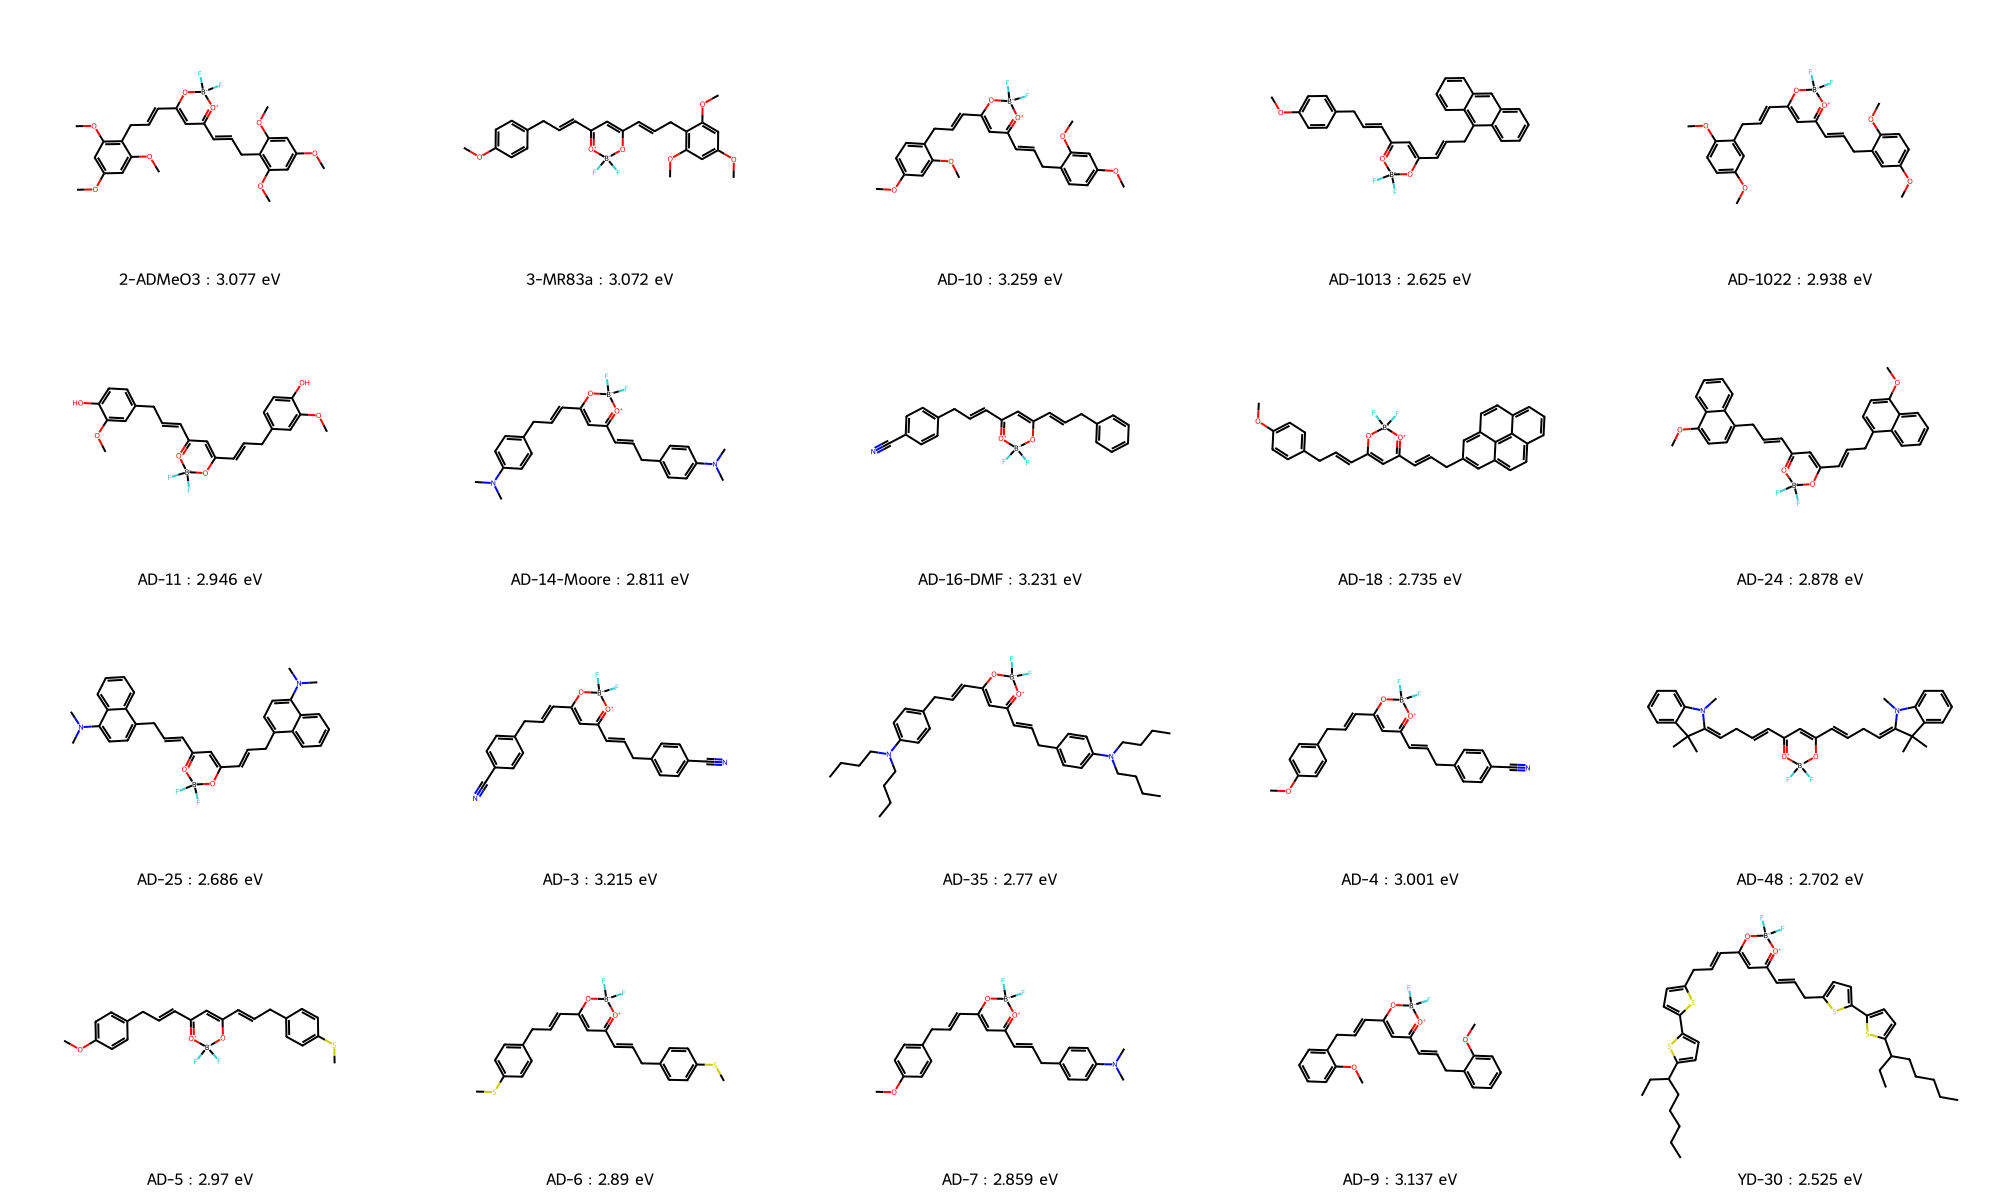

In [ ]:
from rdkit.Chem import Draw
# Molecules generation
legends = [f"{name} : {gap} eV" for name, gap in zip(molecule_names, homo_lumo_gap)]
Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(400,300), legends=legends)

In [4]:
%%time
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
from rdkit.DataStructs import ExplicitBitVect
import numpy as np

# Functions to generate fingerprints
def generate_morgan_fingerprint(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)

def generate_maccs166_fingerprint(mol):
    return MACCSkeys.GenMACCSKeys(mol)

def generate_atom_pair_fingerprint(mol, nBits=2048):
    fp = rdMolDescriptors.GetAtomPairFingerprint(mol)
    return convert_to_bit_vector(fp, nBits)

def generate_fcfp_fingerprint(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=True)

# Convert any fingerprint to a bit vector
def convert_to_bit_vector(fp, nBits=2048):
    bit_vector = ExplicitBitVect(nBits)
    for bit in fp.GetNonzeroElements().keys():
        bit_vector.SetBit(bit % nBits)
    return bit_vector

# Function to add fingerprint to dataframe
def add_fingerprint_to_df(df, fingerprint_func, fp_name):
    df[fp_name] = df['mol'].apply(fingerprint_func)
    return df

# Function to split fingerprints into separate bit columns
def split_fingerprint_bits(df, fp_column, prefix):
    bit_array = np.array([list(fp) for fp in df[fp_column].values])
    bit_columns = pd.DataFrame(bit_array, columns=[f'{prefix}_{i}' for i in range(bit_array.shape[1])])
    df = pd.concat([df.drop(columns=[fp_column]), bit_columns], axis=1)
    return df

# Assuming opv_df is already defined and 'mol' column has been created
# List of fingerprint generation functions and names
fingerprint_functions = [
    (generate_morgan_fingerprint, 'morgan_fp', 'morgan'),
    (generate_maccs166_fingerprint, 'maccs_fp', 'maccs'),
    (generate_atom_pair_fingerprint, 'atom_pair_fp', 'atom_pair'),
    (generate_fcfp_fingerprint, 'fcfp_fp', 'fcfp')
]

# List to store resulting dataframes
resulting_dfs = []

# Generate and store dataframes with fingerprints
for fp_func, fp_name, prefix in fingerprint_functions:
    df_copy = opv_df.copy()
    df_copy = add_fingerprint_to_df(df_copy, fp_func, fp_name)
    df_copy = split_fingerprint_bits(df_copy, fp_name, prefix)
    resulting_dfs.append(df_copy)
    print(f'Finished processing {prefix} fingerprints')

# The resulting_dfs list now contains your four dataframes with split fingerprint columns
opv_df_morgan = resulting_dfs[0]
opv_df_maccs = resulting_dfs[1]
opv_df_atom_pair = resulting_dfs[2]
opv_df_fcfp = resulting_dfs[3]

Finished processing morgan fingerprints
Finished processing maccs fingerprints
Finished processing atom_pair fingerprints
Finished processing fcfp fingerprints
CPU times: total: 2min 44s
Wall time: 6min 43s


In [3]:
%%time
import pandas as pd
from sklearn.model_selection import train_test_split
from pycaret.regression import *
import time

# Define the fingerprint datasets
fingerprint_datasets = [
    (opv_df_morgan, 'Morgan'),
    (opv_df_maccs, 'MACCS'),
    (opv_df_atom_pair, 'AtomPair'),
    (opv_df_fcfp, 'FCFP')
]

def train_models_and_get_results(fingerprint_data, fingerprint_name):
    print(f"Processing the training of {fingerprint_name}...")
    start_time = time.time()
    
    # Splitting the data
    X = fingerprint_data.iloc[:, 3:]
    y = fingerprint_data["GAP_calib"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Preparing the data for PyCaret
    setup_data = pd.concat([X_train, y_train], axis=1)

    # Setting up PyCaret regression
    regression_setup = setup(setup_data, target='GAP_calib', verbose=False, session_id=123)

    # Selecting and comparing models
    models_to_include = ['lightgbm', 'br', 'knn', 'par']
    best_model = compare_models(include=models_to_include, sort='r2', verbose=False)
    
    # Pulling the results
    results = pull()

    # Adding the fingerprint type and time taken to the results
    results['Fingerprint Type'] = fingerprint_name
    results['Time Taken (s)'] = time.time() - start_time

    print(f"Completed pulling results of {fingerprint_name}")

    return results, best_model

all_results = []
best_models = {}

for fp_data, fp_name in fingerprint_datasets:
    fp_results, best_model = train_models_and_get_results(fp_data, fp_name)
    all_results.append(fp_results)
    best_models[fp_name] = best_model

final_results = pd.concat(all_results, ignore_index=True)
final_results.to_csv(path_or_buf=r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\Phase01.csv")
final_results.head()

Processing the training of Morgan...
Completed pulling results of Morgan
Processing the training of MACCS...
Completed pulling results of MACCS
Processing the training of AtomPair...
Completed pulling results of AtomPair
Processing the training of FCFP...


In [2]:
import pandas as pd
path = (r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\Phase01.csv")
final_results = pd.read_csv(path)
final_results

,Unnamed: 0,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),Fingerprint Type,Time Taken (s)
0,0,Light Gradient Boosting Machine,0.1602,0.0508,0.2234,0.8673,0.0582,0.0610,2.109,Morgan,161.588898
1,1,Bayesian Ridge,0.1793,0.0623,0.2482,0.8368,0.0675,0.0696,9.329,Morgan,161.588898
2,2,K Neighbors Regressor,0.1954,0.0787,0.2792,0.7938,0.0760,0.0778,2.494,Morgan,161.588898
3,3,Passive Aggressive Regressor,0.2332,0.0959,0.3087,0.7480,0.0841,0.0901,0.922,Morgan,161.588898
4,4,Light Gradient Boosting Machine,0.2315,0.0964,0.3095,0.7471,0.0827,0.0894,0.342,MACCS,11.351094
5,5,K Neighbors Regressor,0.2415,0.1102,0.3311,0.7105,0.0899,0.0943,0.229,MACCS,11.351094
6,6,Bayesian Ridge,0.2992,0.1534,0.3912,0.5966,0.1065,0.1176,0.213,MACCS,11.351094
7,7,Passive Aggressive Regressor,0.3556,0.2114,0.4582,0.4441,0.1248,0.1415,0.076,MACCS,11.351094
8,8,Light Gradient Boosting Machine,0.2583,0.1271,0.3556,0.6663,0.0969,0.1026,0.965,AtomPair,144.205276
9,9,K Neighbors Regressor,0.2763,0.1525,0.3898,0.5994,0.1071,0.1103,2.397,AtomPair,144.205276


In [3]:
import plotly.graph_objects as go
# Create a bar plot
fig = go.Figure()

# Add bars for each fingerprint type
for fingerprint_type in final_results['Fingerprint Type'].unique():
    filtered_df = final_results[final_results['Fingerprint Type'] == fingerprint_type]
    fig.add_trace(go.Bar(
        x=filtered_df['Model'],
        y=filtered_df['R2'],
        name=fingerprint_type,
        text=filtered_df['R2'].round(4),
        textposition='auto' 
    ))

# Update layout
fig.update_layout(
    title='Model R2 Scores by Fingerprint Type',
    xaxis_title='Model',
    yaxis_title='R2 Score',
    barmode='group',  # Group bars together
    height=600,
    width=1150
)

# Show the plot
fig.show()

In [4]:
import plotly.graph_objects as go

# Find the best model and fingerprint type
best_row = final_results.loc[final_results['R2'].idxmax()]
best_model = best_row['Model']
best_fingerprint_type = best_row['Fingerprint Type']
best_r2 = best_row['R2']

# Create a bar plot
fig = go.Figure()

# Add bars for each fingerprint type
for fingerprint_type in final_results['Fingerprint Type'].unique():
    filtered_df = final_results[final_results['Fingerprint Type'] == fingerprint_type]
    fig.add_trace(go.Bar(
        x=filtered_df['Model'],
        y=filtered_df['R2'],
        name=fingerprint_type,
        text=filtered_df['R2'].round(4),
        textposition='auto',
        marker=dict(color=['red' if (row['Model'] == best_model and row['Fingerprint Type'] == best_fingerprint_type) else 'blue' for index, row in filtered_df.iterrows()])
    ))

# Add annotation for the best model
fig.add_annotation(
    x=best_model,
    y=best_r2,
    text=f"Best Model: {best_model}<br>Fingerprint Type: {best_fingerprint_type}<br>R2: {best_r2:.4f}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40
)

# Update layout
fig.update_layout(
    title='Model R2 Scores by Fingerprint Type',
    xaxis_title='Model',
    yaxis_title='R2 Score',
    barmode='group',  # Group bars together
    height=800,
    width=1000
)

# Show the plot
fig.show()

In [2]:
def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception:
        return None
    return None

# apply morgan fingerprint to the curcumin_df dataframe
curcumin_df['Morgan_Fingerprints'] = curcumin_df['Smiles'].apply(generate_morgan_fingerprint_safe)
curcumin_df = curcumin_df[curcumin_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_df = pd.DataFrame(curcumin_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

curcumin_df_mf = pd.concat([curcumin_df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)

In [5]:
%%time
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

# Load your dataset
X = opv_df_morgan.iloc[:, 3:]
y = opv_df_morgan["GAP_calib"]

reg1 = pd.concat([X, y], axis=1)
X = reg1.drop('GAP_calib', axis=1)
y = reg1['GAP_calib']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LightGBM model with the specified hyperparameters
lgb_model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    class_weight=None,
    colsample_bytree=1.0,
    importance_type='split',
    learning_rate=0.1,
    max_depth=-1,
    min_child_samples=20,
    min_child_weight=0.001,
    min_split_gain=0.0,
    n_estimators=100,
    n_jobs=-1,
    num_leaves=31,
    objective=None,
    random_state=123,
    reg_alpha=0.0,
    reg_lambda=0.0,
    subsample=1.0,
    subsample_for_bin=200000,
    subsample_freq=0
)

# Initialize tqdm progress bar
bar = tqdm_notebook(total=100, desc="Training Progress")

# Function to update tqdm progress bar
def lgb_tqdm_callback(env):
    bar.update(env.iteration - bar.n)

# Fit the model with tqdm callback
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb_tqdm_callback]
)

# Close the progress bar after training is done
bar.close()

# Make predictions
y_pred_train = lgb_model.predict(X_train)
y_pred_test = lgb_model.predict(X_test)

# Calculate evaluation metrics
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 41004, number of used features: 1541
[LightGBM] [Info] Start training from score 2.807195
Train RMSE: 0.21089943047660412
Test RMSE: 0.22139888475355485
Train R2: 0.8826323902982751
Test R2: 0.8688760472850489
CPU times: total: 18.3 s
Wall time: 11.8 s


RMSE: 0.2130408878527318
R2: 0.8799119731398293


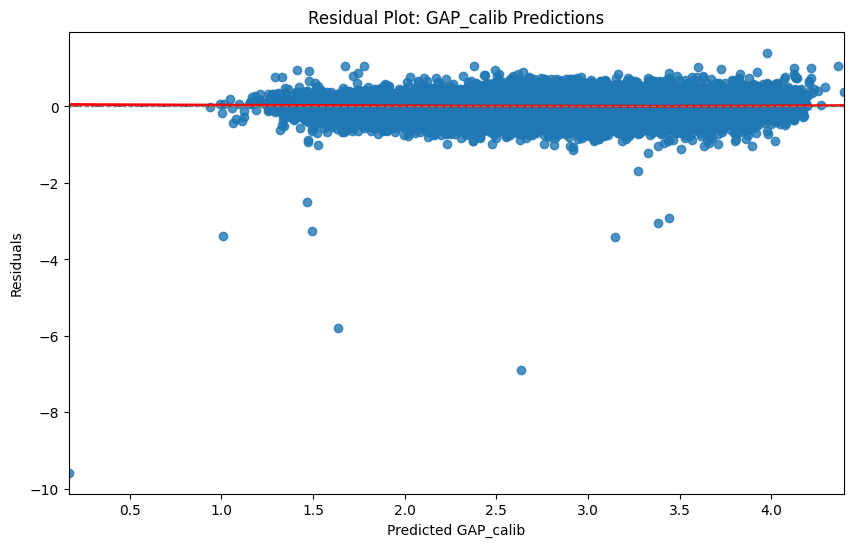

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Predict GAP_calib values
opv_df_morgan_pred = opv_df_morgan.drop(opv_df_morgan.columns[3:], axis=1)
opv_df_morgan_pred['GAP_calib_pred'] = lgb_model.predict(opv_df_morgan.iloc[:, 3:])

# Calculate RMSE and R2 scores
rmse = mean_squared_error(opv_df_morgan_pred['GAP_calib'], opv_df_morgan_pred['GAP_calib_pred'], squared=False)
r2 = r2_score(opv_df_morgan_pred['GAP_calib'], opv_df_morgan_pred['GAP_calib_pred'])

print(f'RMSE: {rmse}')
print(f'R2: {r2}')

# Plot residual graph
residuals = opv_df_morgan_pred['GAP_calib'] - opv_df_morgan_pred['GAP_calib_pred']

plt.figure(figsize=(10, 6))
sns.residplot(x=opv_df_morgan_pred['GAP_calib_pred'], y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Predicted GAP_calib')
plt.ylabel('Residuals')
plt.title('Residual Plot: GAP_calib Predictions')
plt.show()

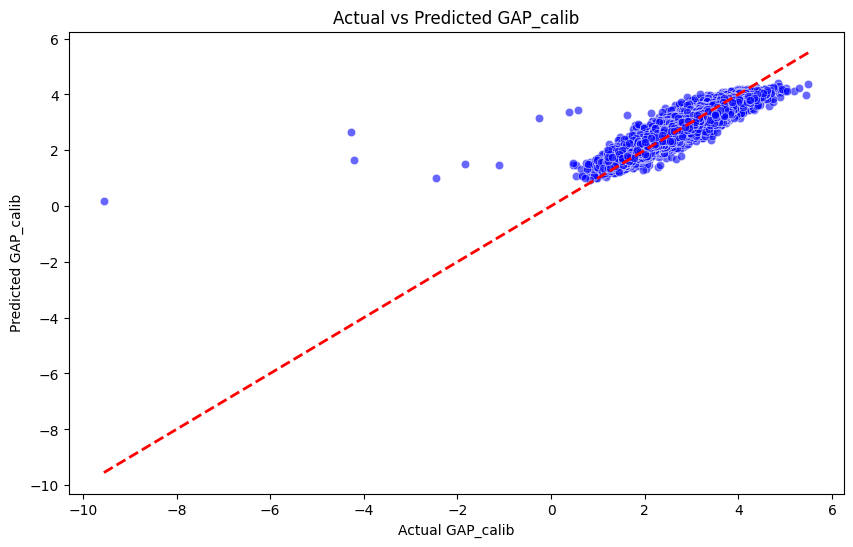

In [8]:
# Scatter plot for Actual vs Predicted GAP_calib values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=opv_df_morgan_pred['GAP_calib'], y=opv_df_morgan_pred['GAP_calib_pred'], color='blue', alpha=0.6)
plt.plot([opv_df_morgan_pred['GAP_calib'].min(), opv_df_morgan_pred['GAP_calib'].max()],
         [opv_df_morgan_pred['GAP_calib'].min(), opv_df_morgan_pred['GAP_calib'].max()],
         color='red', linestyle='--', linewidth=2)

plt.xlabel('Actual GAP_calib')
plt.ylabel('Predicted GAP_calib')
plt.title('Actual vs Predicted GAP_calib')
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

# predicting the Homo-Lumo Gap (eV) values for the curcumin dataset
curcumin_df_mf = curcumin_df_mf.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)
curcumin_df_mf_pred = curcumin_df_mf.drop(curcumin_df_mf.columns[5:], axis=1)
curcumin_df_mf_pred['Homo-Lumo Gap (eV) pred'] = lgb_model.predict(curcumin_df_mf.iloc[:,6:])
curcumin_df_mf_pred.head()

# calculate the RMSE and R2 scores for each Homo-Lumo Gap (eV) and gap_calib_pred values
rmse = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) pred'], squared=False)
r2 = r2_score(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) pred'])

print(f'RMSE: {rmse}')
print(f'R2: {r2}')

RMSE: 0.19349947503849355
R2: 0.0907981837070645


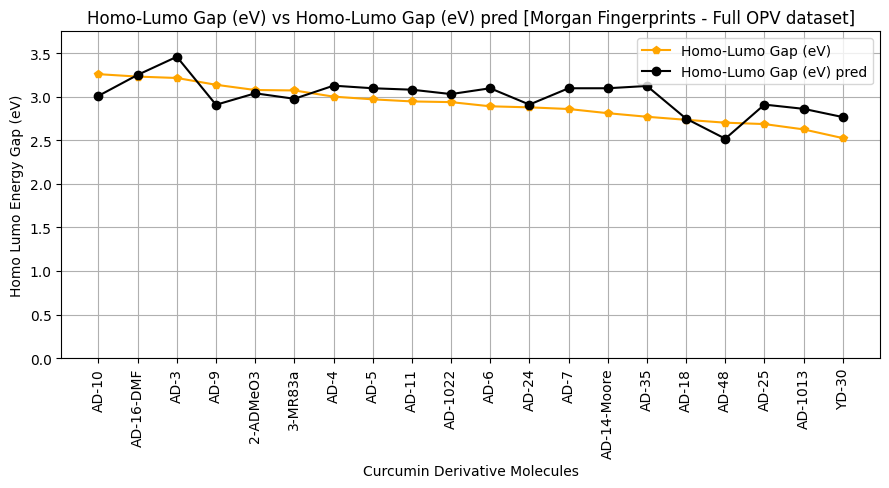

In [10]:
# Plotting the GAP and GAP_pred values against molecule names
plt.figure(figsize=(9,4))
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker= 'p', label='Homo-Lumo Gap (eV)',color = "orange")
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) pred'], marker= 'o', label='Homo-Lumo Gap (eV) pred', color = "black")
plt.xlabel('Curcumin Derivative Molecules')
plt.ylabel('Homo Lumo Energy Gap (eV)')
plt.grid(True)
plt.tight_layout()
plt.title('Homo-Lumo Gap (eV) vs Homo-Lumo Gap (eV) pred [Morgan Fingerprints - Full OPV dataset]')
plt.legend()
plt.ylim(0,3.75)
plt.xticks(rotation=90)
plt.show()

In [7]:
%%time
best_params = {'learning_rate': 0.23685145356420312, 'n_estimators': 1000, 'num_leaves': 51}
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 41004, number of used features: 1541
[LightGBM] [Info] Start training from score 2.807195
Train RMSE: 0.07417295797052453
Test RMSE: 0.15617664915280902
Train R2: 0.9854826066758385
Test R2: 0.9347525751401733
CPU times: total: 24.2 s
Wall time: 6.86 s


RMSE: 0.09633185417945066
R2: 0.9754464879132948


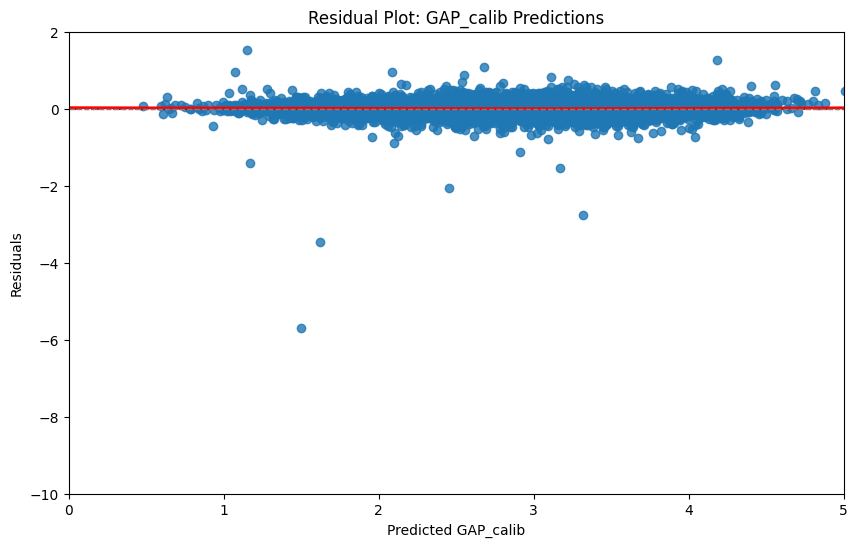

In [9]:
# Predicting the GAP_calib values for the OPV dataset
opv_df_morgan_pred = opv_df_morgan.drop(opv_df_morgan.columns[3:], axis=1)
opv_df_morgan_pred['GAP_calib_pred'] = best_model.predict(opv_df_morgan.iloc[:,3:])

# calculate the RMSE and R2 scores for each gap_calib and gap_calib_pred values
from sklearn.metrics import mean_squared_error, r2_score

rmse = mean_squared_error(opv_df_morgan_pred['GAP_calib'], opv_df_morgan_pred['GAP_calib_pred'], squared=False)
r2 = r2_score(opv_df_morgan_pred['GAP_calib'], opv_df_morgan_pred['GAP_calib_pred'])

print(f'RMSE: {rmse}')
print(f'R2: {r2}')

# Plot residual graph
residuals = opv_df_morgan_pred['GAP_calib'] - opv_df_morgan_pred['GAP_calib_pred']

plt.figure(figsize=(10, 6))
sns.residplot(x=opv_df_morgan_pred['GAP_calib_pred'], y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Predicted GAP_calib')
plt.ylim(-10, 2)
plt.xlim(0, 5)
plt.ylabel('Residuals')
plt.title('Residual Plot: GAP_calib Predictions')
plt.show()

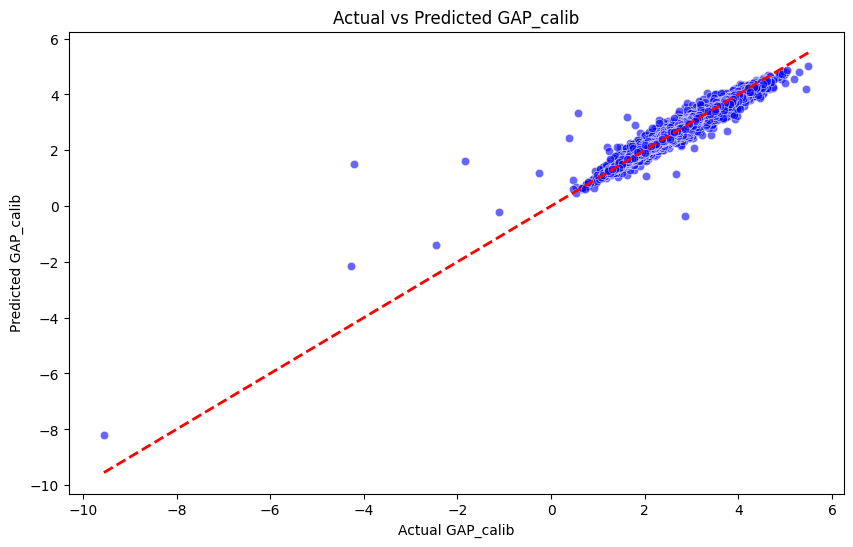

In [14]:
# Scatter plot for Actual vs Predicted GAP_calib values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=opv_df_morgan_pred['GAP_calib'], y=opv_df_morgan_pred['GAP_calib_pred'], color='blue', alpha=0.6)
plt.plot([opv_df_morgan_pred['GAP_calib'].min(), opv_df_morgan_pred['GAP_calib'].max()],
         [opv_df_morgan_pred['GAP_calib'].min(), opv_df_morgan_pred['GAP_calib'].max()],
         color='red', linestyle='--', linewidth=2)

plt.xlabel('Actual GAP_calib')
plt.ylabel('Predicted GAP_calib')
plt.title('Actual vs Predicted GAP_calib')
plt.show()

RMSE: 0.2345930202449501
R2: -0.33638282510271345


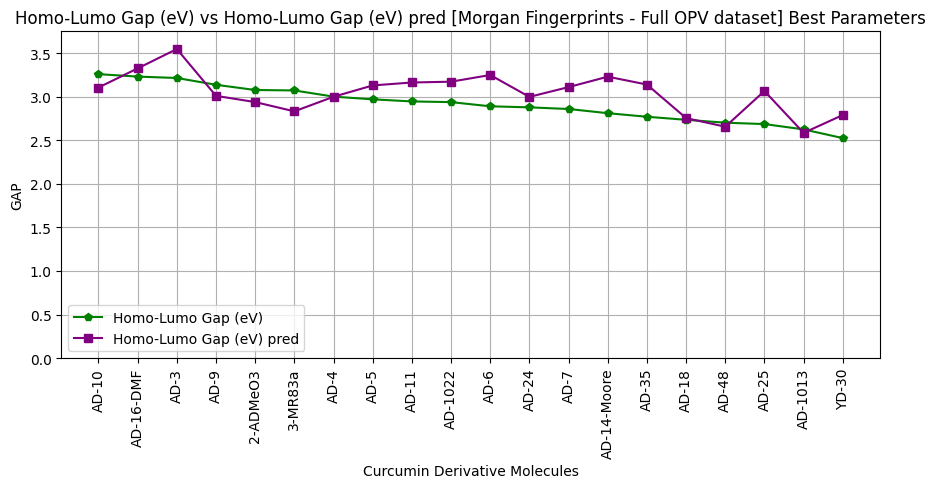

In [17]:
# predicting the Homo-Lumo Gap (eV) values for the curcumin dataset
curcumin_df_mf_pred = curcumin_df_mf.drop(curcumin_df_mf.columns[6:], axis=1)
curcumin_df_mf_pred['Homo-Lumo Gap (eV) pred'] = best_model.predict(curcumin_df_mf.iloc[:,6:])
curcumin_df_mf_pred.head()

# calculate the RMSE and R2 scores for each Homo-Lumo Gap (eV) and gap_calib_pred values
rmse = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) pred'], squared=False)
r2 = r2_score(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) pred'])

print(f'RMSE: {rmse}')
print(f'R2: {r2}')

# Plotting the GAP and GAP_pred values against molecule names
plt.figure(figsize=(9,4))
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker= 'p', label='Homo-Lumo Gap (eV)',color = "green")
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) pred'], marker= 's', label='Homo-Lumo Gap (eV) pred', color = "purple")
plt.xlabel('Curcumin Derivative Molecules')
plt.ylabel('GAP')
plt.grid(True)
plt.tight_layout()
plt.title('Homo-Lumo Gap (eV) vs Homo-Lumo Gap (eV) pred [Morgan Fingerprints - Full OPV dataset] Best Parameters')
plt.legend()
plt.ylim(0,3.75)
plt.xticks(rotation=90)
plt.show()